# House Prices Prediction using Gradient Boosting and PCA + Lasso
This notebook performs house price prediction using:
- **GradientBoostingRegressor** from `sklearn`
- **PCA + LassoCV** regression model
It applies preprocessing, polynomial features, dimensionality reduction, and model evaluation based on log RMSE.  

Several models were considered for this particular Kaggle competition including linear, non-linear and tree-based. My selection was semi-random in that I wanted one linear method and one non-linear tree-based method. So I selected gradient boosting and PCA/LassoCV.
Submissions files are generated for Kaggle

## 1. Import Required Libraries and Load Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["Id"]

## 2. Combine Train and Test for Uniform Preprocessing

In [9]:

# Tag and merge
train["source"] = "train"
test["source"] = "test"
test["SalePrice"] = np.nan
full = pd.concat([train, test], sort=False)

# Drop Id now that it's saved
full.drop("Id", axis=1, inplace=True)

# Split before defining features
train = full[full["source"] == "train"].copy()
test = full[full["source"] == "test"].copy()
train.drop(columns="source", inplace=True)
test.drop(columns=["source", "SalePrice"], inplace=True)


## 3. Define Feature Types and Preprocessing Pipelines

In [10]:
# Identify feature columns
features = full.drop(columns=["SalePrice", "source"])
num_cols = features.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = features.select_dtypes(include=["object"]).columns.tolist()

# Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

## 4. Define Training Data and RMSE Function

In [11]:
X = train.drop(columns="SalePrice")
y = np.log1p(train["SalePrice"])

def rmse_log(preds, actuals):
    return np.sqrt(mean_squared_error(np.log1p(actuals), np.log1p(preds)))

rmse_results = []


## 5. Train GradientBoostingRegressor

In [12]:
gbr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("gbr", GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                      max_depth=4, random_state=42))
])
gbr_pipeline.fit(X, y)
gbr_preds_train = np.expm1(gbr_pipeline.predict(X))
gbr_preds_test = np.expm1(gbr_pipeline.predict(test))
rmse_gbr = rmse_log(gbr_preds_train, np.expm1(y))
rmse_results.append(("GradientBoostingRegressor", rmse_gbr))
pd.DataFrame({"Id": test_ids, "SalePrice": gbr_preds_test}).to_csv("submission_gbr.csv", index=False)

## 6. Train PCA + Lasso Model

In [13]:
lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("pca", PCA(n_components=100)),
    ("lasso", LassoCV(cv=5))
])
lasso_pipeline.fit(X, y)
lasso_preds_train = np.expm1(lasso_pipeline.predict(X))
lasso_preds_test = np.expm1(lasso_pipeline.predict(test))
rmse_lasso = rmse_log(lasso_preds_train, np.expm1(y))
rmse_results.append(("PCA + Lasso", rmse_lasso))
pd.DataFrame({"Id": test_ids, "SalePrice": lasso_preds_test}).to_csv("submission_lasso.csv", index=False)

## 7. Compare Model RMSEs

                       Model  Log RMSE
0  GradientBoostingRegressor  0.051105
1                PCA + Lasso  0.127668


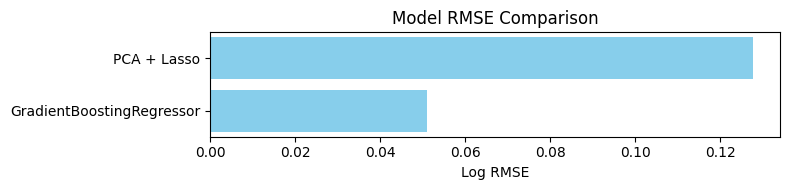

In [14]:
rmse_df = pd.DataFrame(rmse_results, columns=["Model", "Log RMSE"])
print(rmse_df)

plt.figure(figsize=(8, 2))
plt.barh(rmse_df["Model"], rmse_df["Log RMSE"], color="skyblue")
plt.xlabel("Log RMSE")
plt.title("Model RMSE Comparison")
plt.tight_layout()
plt.show("rmse_comparison.png")

## 8. Final Comments
Both models use effective preprocessing techniques:
- GBR captures non-linear interactions robustly.
- PCA + Lasso uses polynomial expansion and dimensionality reduction.

Submissions were saved to:
- `submission_gbr.csv`
- `submission_lasso.csv`

The plot (`rmse_comparison.png`) shows model performance.